# Install dependencies

* If already installed in colab, this step can be optional

In [2]:
!pip install -q langchain langchain-community langchain-google-genai google-generativeai==0.8.5 google-ai-generativelanguage==0.6.15


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


# Insert your LLM API Key

* I have used Gemini by default

In [3]:
from getpass import getpass
import os

api_key = getpass("Paste your Google AI Studio (Gemini) API key here: ")
os.environ["GOOGLE_API_KEY"] = api_key
print("✅ API key set")


Paste your Google AI Studio (Gemini) API key here: ··········
✅ API key set


# Paste note text directly into the box

In [7]:

# Ask user to paste their note
doc_text = input("✍️ Please paste your note here:\n\n")

# Quick feedback
print("\n✅ Note captured. First 500 chars:\n")
print(doc_text[:500])


✍️ Please paste your note here:

High school seniors had the worst reading scores since 1992 on a national test, a loss probably related to increases in screen time and the pandemic. Their math scores fell as well. The reading skills of American high school seniors are the worst they have been in three decades, according to new federal testing data, a worrying sign for teenagers as they face an uncertain job market and information landscape challenged by A.I.  In math, 12th graders had the lowest performance since 2005.  The results, from the National Assessment of Educational Progress, long regarded as the nation’s most reliable, gold-standard exam, showed that about a third of the 12th-graders who were tested last year did not have basic reading skills.  It was a sign that, among other skills, they may not be able to determine the purpose of a political speech. In math, nearly half of the test takers scored below the basic level, meaning they may not have mastered skills like using p

## Initialize LLM + memory

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.memory import ConversationBufferMemory

llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0.0)
memory = ConversationBufferMemory(return_messages=True)
print("✅ LLM and memory initialized")


✅ LLM and memory initialized


/tmp/ipython-input-3144195714.py:5: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages=True)


## Define tools

In [14]:
from langchain.tools import tool

tasks = []  # global in-memory task list

@tool
def search_notes(query: str) -> str:
    """Search uploaded notes for relevant content."""
    q = query.lower()
    hits = []
    for line in doc_text.splitlines():
        if q in line.lower():
            hits.append(line.strip())
    return "\n".join(hits) if hits else "No matches found."

@tool
def summarize_notes(query: str = "") -> str:
    """Summarize uploaded notes (optionally guided by query)."""
    # If no query, summarize the full note
    snippet = doc_text if not query else search_notes.run(query)
    prompt = f"Summarize the following text into 3-5 concise bullet points:\n\n{snippet}"
    res = llm.invoke(prompt)
    return getattr(res, "content", str(res))

@tool
def create_task(title: str) -> str:
    """Create a task (requires human confirmation)."""
    confirm = input(f"Confirm creation of task '{title}'? (y/N): ").strip().lower()
    if confirm == "y":
        tasks.append(title)
        return f"✅ Task created: {title}"
    else:
        return "❌ Task cancelled."

@tool
def show_tasks(dummy: str="") -> str:
    """Show current tasks."""
    return "\n".join([f"{i+1}. {t}" for i,t in enumerate(tasks)]) if tasks else "No tasks yet."


## Bind tools to Gemini

In [10]:
tools = [search_notes, summarize_notes, create_task, show_tasks]
llm_with_tools = llm.bind_tools(tools)
print("✅ Tools bound to Gemini")


✅ Tools bound to Gemini


# Agent loop
* the brain

In [19]:
def agent_with_tools(user_input: str) -> str:
    """
    Agent logic:
    1. Check if input indicates a tool should be used
    2. Run the tool (summarize/search/create/show)
    3. Feed tool output + conversation memory back to LLM
    """
    # Save user input
    memory.save_context({"input": user_input}, {"output": ""})

    # Simple keyword routing for demo
    tool_output = ""
    if "summarize" in user_input.lower():
        tool_output = summarize_notes.invoke("")  # <-- pass empty string
    elif "search" in user_input.lower():
        tool_output = search_notes.invoke(user_input)
    elif "create task" in user_input.lower():
        title = input("Enter task title for creation: ")
        tool_output = create_task.invoke(title)
    elif "show tasks" in user_input.lower():
        tool_output = show_tasks.invoke("")  # <-- pass empty string

    # Build LLM prompt with memory + tool output
    context = f"Document note:\n{doc_text}\n\nConversation so far:\n"
    for msg in memory.buffer:
        if 'input' in msg: context += f"User: {msg['input']}\n"
        if 'output' in msg: context += f"Agent: {msg['output']}\n"

    prompt = context + f"User: {user_input}\nTool output:\n{tool_output}\nAgent:"

    # Call LLM
    res = llm.invoke(prompt)
    text = getattr(res, "content", str(res))

    # Save agent output to memory
    memory.save_context({"input": user_input}, {"output": text})
    return text


## Visualize Agent Flow with NetworkX


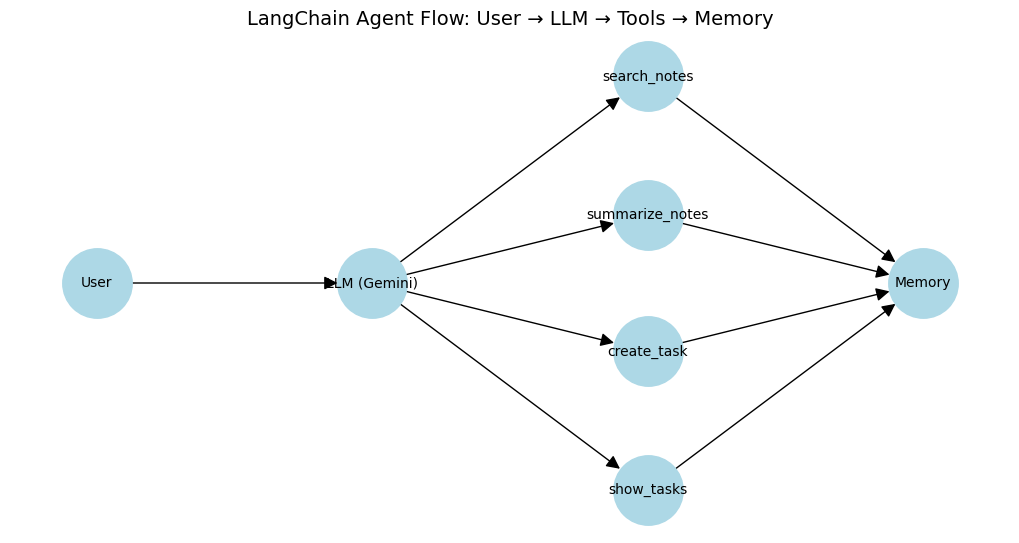

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Nodes
G.add_node("User")
G.add_node("LLM (Gemini)")
G.add_node("search_notes")
G.add_node("summarize_notes")
G.add_node("create_task")
G.add_node("show_tasks")
G.add_node("Memory")

# Edges
G.add_edges_from([
    ("User", "LLM (Gemini)"),
    ("LLM (Gemini)", "search_notes"),
    ("LLM (Gemini)", "summarize_notes"),
    ("LLM (Gemini)", "create_task"),
    ("LLM (Gemini)", "show_tasks"),
    ("search_notes", "Memory"),
    ("summarize_notes", "Memory"),
    ("create_task", "Memory"),
    ("show_tasks", "Memory")
])

# Define positions for nodes for nicer layout
pos = {
    "User": (0,0),
    "LLM (Gemini)": (1,0),
    "search_notes": (2,1),
    "summarize_notes": (2,0.33),
    "create_task": (2,-0.33),
    "show_tasks": (2,-1),
    "Memory": (3,0)
}

# Draw the graph
plt.figure(figsize=(10,5))
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="lightblue", arrowsize=20, font_size=10)
plt.title("LangChain Agent Flow: User → LLM → Tools → Memory", fontsize=14)
plt.show()


## Interactive chat

Users can type natural language like:

* Summarize this document

* Create a task to email John about prototype testing

* Show my tasks

* Find mentions of cycle life

Any generic questions asked directly to the LLM will also work.

**Note:** to end the converstion, enter 'exit' or 'quit'

In [20]:
while True:
    q = input("\nYou: ")
    if q.lower() in ["exit", "quit"]:
        break
    print("Agent:", agent_with_tools(q))



You: hi
Agent: Hello! I've read the document note you provided about the declining reading and math scores for high school seniors.

How can I help you with it? For example, you could ask me to:

*   Summarize the key findings.
*   Identify the potential causes mentioned for the score decline.
*   Pull out specific statistics.
*   Explain the different perspectives on how to solve the problem.

You: can you summarize the key findings for me?
Agent: Based on the document, here are the main takeaways:

*   **The problem is severe and widespread:** This isn't a minor dip in scores. It's a "stark decline" to the lowest levels in decades. A large percentage of students are leaving high school without the basic reading and math skills needed for college, skilled jobs, or even to understand a political speech.

*   **There are multiple causes:** The decline is attributed to a combination of factors. The immediate disruption of the COVID-19 pandemic is a major cause, but it's layered on top o